In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization,concatenate
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# Voor GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:
# Dice coefficient loss

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [3]:
# IMG inladen

Lung_images = []

Lung_path = "./Lung_images"

for f in os.listdir(Lung_path):
    if ".png" in f:
        img = np.asarray(cv2.imread(os.path.join(Lung_path,f), cv2.IMREAD_GRAYSCALE))
        img = transform.resize(img,(400,400),mode='constant',anti_aliasing=True)
        Lung_images.append(img)

Lung_masks = []

Mask_path = "./Lung_masks"

for f in os.listdir(Mask_path):
    if ".png" in f:
        img = np.asarray(cv2.imread(os.path.join(Mask_path,f), cv2.IMREAD_GRAYSCALE))
        img = transform.resize(img,(400,400),mode='constant',anti_aliasing=True)
        Lung_masks.append(img)

In [4]:
# training en test set maken

X_train, X_test, y_train, y_test = train_test_split(Lung_images, Lung_masks, test_size = 20, random_state =69)

In [5]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [6]:
Lung_masks = np.round(Lung_masks)
X_train = X_train.reshape(X_train.shape[0], 400, 400, 1)
X_test = X_test.reshape(X_test.shape[0], 400, 400, 1)

y_train = y_train.reshape(y_train.shape[0], 400, 400, 1)
y_test = y_test.reshape(y_test.shape[0], 400, 400, 1)

In [15]:
# Autoencoder

input_img = Input(shape=(400, 400, 1))  

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# representation is  (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss=dice_coef_loss, metrics=['accuracy'])
autoencoder.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 400, 400, 1)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 400, 400, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 200, 200, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 200, 200, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 200, 200, 32)     

In [16]:
epochs = 50
batchsize = 8
#earlystopper = EarlyStopping(patience=5, verbose=1)
#checkpointer = ModelCheckpoint('imgseg.h5', verbose=1, save_best_only=True)
history = autoencoder.fit(X_train, y_train,
                epochs=epochs,
                callbacks=[earlystopper, checkpointer],
                batch_size=batchsize,
                shuffle=True).history

Train on 684 samples
Epoch 1/50
684/684 [==============================] - 14s 21ms/sample - loss: 0.0985 - accuracy: 0.7366
Epoch 2/50
684/684 [==============================] - 14s 20ms/sample - loss: 0.0653 - accuracy: 0.7701
Epoch 3/50
684/684 [==============================] - 14s 20ms/sample - loss: 0.0563 - accuracy: 0.7905
Epoch 4/50
684/684 [==============================] - 14s 20ms/sample - loss: 0.0514 - accuracy: 0.8015
Epoch 5/50
684/684 [==============================] - 14s 20ms/sample - loss: 0.0475 - accuracy: 0.8102
Epoch 6/50
684/684 [==============================] - 14s 21ms/sample - loss: 0.0418 - accuracy: 0.8215
Epoch 7/50
684/684 [==============================] - 14s 21ms/sample - loss: 0.0384 - accuracy: 0.8287
Epoch 8/50
684/684 [==============================] - 14s 21ms/sample - loss: 0.0404 - accuracy: 0.8252
Epoch 9/50
684/684 [==============================] - 14s 21ms/sample - loss: 0.0346 - accuracy: 0.8352
Epoch 10/50
684/684 [======================

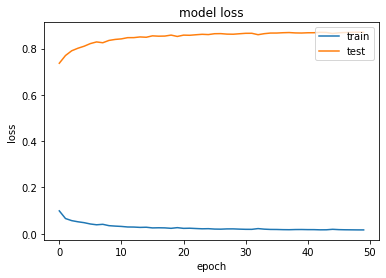

In [17]:
plt.plot(history['loss'])
plt.plot(history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


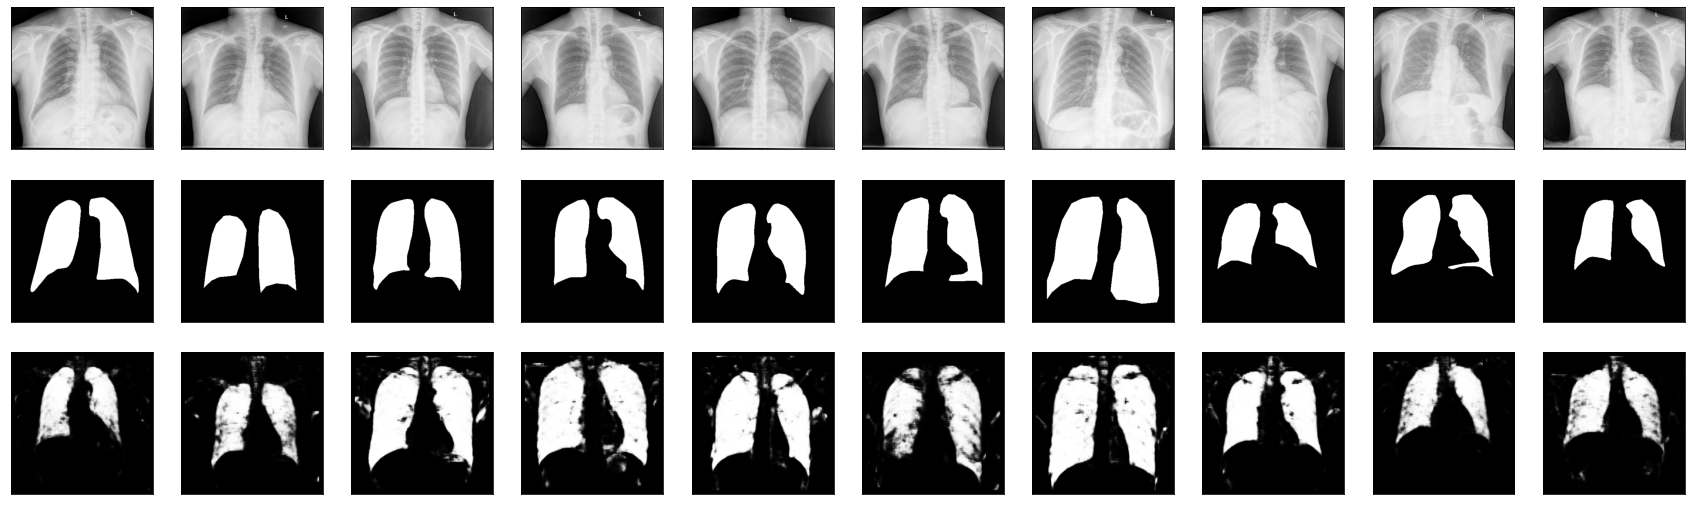

In [18]:
n = 10 # number of images to plot
plt.figure(figsize=(30, 9))

decoded_imgs = autoencoder.predict(np.asarray(X_test[:n]))
for i in range(n):
    # Originals
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(Lung_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Masks
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(Lung_masks[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Reconstructions
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# ONNX

In [26]:
autoencoder.save('./output/imgseg')

INFO:tensorflow:Assets written to: ./output/imgseg\assets


In [28]:
# generating imgseg.onnx using saved_model
!python -m tf2onnx.convert \
        --saved-model ./output/imgseg \
        --output ./output/imgseg.onnx \
        --opset 11

2020-12-28 15:55:20.558820: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
2020-12-28 15:55:24,080 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2020-12-28 15:55:24.327312: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library nvcuda.dll
2020-12-28 15:55:24.417988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 950 computeCapability: 5.2
coreClock: 1.2405GHz coreCount: 6 deviceMemorySize: 2.00GiB deviceMemoryBandwidth: 98.50GiB/s
2020-12-28 15:55:24.418026: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
2020-12-28 15:55:24.426110: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cublas64_10.dll
2020-12-28 15:55:24.450584: I tensorflow/stream_execut

In [60]:
def add(x, y):
    return tf.nn.bias_add(x, y, data_format="NHWC")

def conv2d(x, w):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME', data_format="NHWC")


def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME', data_format="NHWC")


def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.compat.v1.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [61]:
def deepnn(x):
    """deepnn builds the graph for a deep net for classifying digits.
    Args:
      x: an input tensor with the dimensions (N_examples, 784), where 784 is the
      number of pixels in a standard MNIST image.
    Returns:
      A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
      equal to the logits of classifying the digit into one of 10 classes (the
      digits 0-9). keep_prob is a scalar placeholder for the probability of dropout.
    """
    # Reshape to use within a convolutional neural net.
    # Last dimension is for "features" - there is only one here, since images are
    # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 1, 28, 28])
    x_image = tf.transpose(x_image, [0, 2, 3, 1])

    # First convolutional layer - maps one grayscale image to 32 feature maps.
    with tf.name_scope('conv1'):
        w_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(add(conv2d(x_image, w_conv1), b_conv1))

    # Pooling layer - downsamples by 2X.
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1)

    # Second convolutional layer -- maps 32 feature maps to 64.
    with tf.name_scope('conv2'):
        w_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(add(conv2d(h_pool1, w_conv2), b_conv2))

    # Second pooling layer.
    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv2)

    # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
    # is down to 7x7x64 feature maps -- maps this to 1024 features.
    with tf.name_scope('fc1'):
        w_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])

        h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

    # Map the 1024 features to 10 classes, one for each digit
    with tf.name_scope('fc2'):
        w_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])

        y_conv = tf.matmul(h_fc1, w_fc2) + b_fc2

    return y_conv

In [70]:
def create_and_train_mnist():
    #tf.logging.set_verbosity(tf.logging.ERROR)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    # Import data
    data_dir = r"/tmp/tensorflow/mnist/input_data"
    mnist = input_data.read_data_sets(data_dir)
    # Create the model
    tf.compat.v1.reset_default_graph()
    input_tensor = tf.placeholder(tf.float32, [None, 784], name="input")
    # Build the graph for the deep net
    y_conv = deepnn(input_tensor)
    output_tensor = tf.identity(y_conv, "result")
    with open("./output/graph.proto", "wb") as file:
        graph = tf.get_default_graph().as_graph_def(add_shapes=True)
        file.write(graph.SerializeToString())
    # Define loss and optimizer
    y_ = tf.placeholder(tf.int64, [None])
    with tf.name_scope('loss'):
        cross_entropy = tf.losses.sparse_softmax_cross_entropy(
            labels=y_, logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)
    with tf.name_scope('adam_optimizer'):
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_)
        correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

    saver = tf.train.Saver()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    for i in range(5000):
        batch = mnist.train.next_batch(50)
        if i % 1000 == 0:
            train_accuracy = accuracy.eval(session=sess, feed_dict={input_tensor: batch[0], y_: batch[1]})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(session=sess, feed_dict={input_tensor: batch[0], y_: batch[1]})

    print('test accuracy %g' % accuracy.eval(session=sess, feed_dict={input_tensor: mnist.test.images[:1000], y_: mnist.test.labels[:1000]}))
    return sess, saver, input_tensor, output_tensor

In [71]:
input_tensor = tf.compat.v1.placeholder(tf.float32, [None, 784], name="input")
# Build the graph for the deep net
y_conv = deepnn(input_tensor)
output_tensor = tf.compat.v1.identity(y_conv, "result")

In [72]:
import os
import shutil
import tensorflow as tf
from tensorflow.saved_model import save
def save_model_to_saved_model(sess, input_tensor, output_tensor):
    save_path = r"./output/saved_model"
    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    save(sess, save_path, {input_tensor.name: input_tensor}, {output_tensor.name: output_tensor})

print("please wait for a while, because the script will train MNIST from scratch")
tf.compat.v1.reset_default_graph()
sess_tf, saver, input_tensor, output_tensor = create_and_train_mnist()
print("save tensorflow in format \"saved_model\"")
save_model_to_saved_model(sess_tf, input_tensor, output_tensor)

please wait for a while, because the script will train MNIST from scratch


NameError: name 'input_data' is not defined

In [66]:
import numpy as np
import onnxruntime as ort

#img = np.load("./assets/image.npz").reshape([1, 784])  
sess_ort = ort.InferenceSession("./output/imgseg.onnx")
res = sess_ort.run(output_names=[output_tensor.name], input_feed={input_tensor.name: X_test})
print("the expected result is \"7\"")
print("the digit is classified as \"%s\" in ONNXRruntime"%np.argmax(res))

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Invalid Feed Input Name:input_12:0

In [33]:
from tf2onnx.tfonnx import process_tf_graph, tf_optimize
import tensorflow as tf
from tensorflow.graph_util import convert_variables_to_constants as freeze_graph

print("generating mnist.onnx in python script")
graph_def = freeze_graph(sess_tf, sess_tf.graph_def, [output_tensor.name[:-2]])
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    onnx_graph = process_tf_graph(graph, opset=7, input_names=[input_tensor.name], output_names=[output_tensor.name])
model_proto = onnx_graph.make_model("test")
print("ONNX model is saved at ./output/mnist4.onnx")
with open("./output/mnist4.onnx", "wb") as f:
    f.write(model_proto.SerializeToString())

ImportError: cannot import name 'convert_variables_to_constants' from 'tensorflow.graph_util' (c:\users\piett\appdata\local\programs\python\python38\lib\site-packages\tensorflow\_api\v2\graph_util\__init__.py)

In [ ]:
import numpy as np
import onnx
import os
import glob
import onnx_backend as backend

from onnx import numpy_helper

model = onnx.load('model.onnx')
test_data_dir = 'test_data_set_0'

# Load inputs
inputs = []
inputs_num = len(glob.glob(os.path.join(test_data_dir, 'input_*.pb')))
for i in range(inputs_num):
    input_file = os.path.join(test_data_dir, 'input_{}.pb'.format(i))
    tensor = onnx.TensorProto()
    with open(input_file, 'rb') as f:
        tensor.ParseFromString(f.read())
    inputs.append(numpy_helper.to_array(tensor))

# Load reference outputs
ref_outputs = []
ref_outputs_num = len(glob.glob(os.path.join(test_data_dir, 'output_*.pb')))
for i in range(ref_outputs_num):
    output_file = os.path.join(test_data_dir, 'output_{}.pb'.format(i))
    tensor = onnx.TensorProto()
    with open(output_file, 'rb') as f:
        tensor.ParseFromString(f.read())
    ref_outputs.append(numpy_helper.to_array(tensor))

# Run the model on the backend
outputs = list(backend.run_model(model, inputs))

# Compare the results with reference outputs.
for ref_o, o in zip(ref_outputs, outputs):
    np.testing.assert_almost_equal(ref_o, o)